In [121]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [122]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [123]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the datasetx
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [124]:
x_train, y_train, x_test, y_test, class_names = load_data('data_npy')

In [125]:
print(class_names)

['circle', 'rectangle', 'triangle']


In [126]:
num_classes = len(class_names)
image_size = 28

rectangle


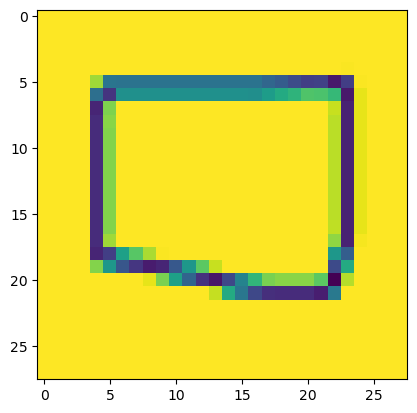

In [127]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

In [128]:
print(class_names[int(y_train[idx].item())])

rectangle


In [129]:
# # Reshape and normalize
# x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
# x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# x_train /= 255.0
# x_test /= 255.0

# # Convert class vectors to class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [130]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

input_shape = (28, 28, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train: ', x_train.shape[0])
print('Number of images in x_test: ', x_test.shape[0])

x_train shape: (48, 28, 28, 1)
Number of images in x_train:  48
Number of images in x_test:  12


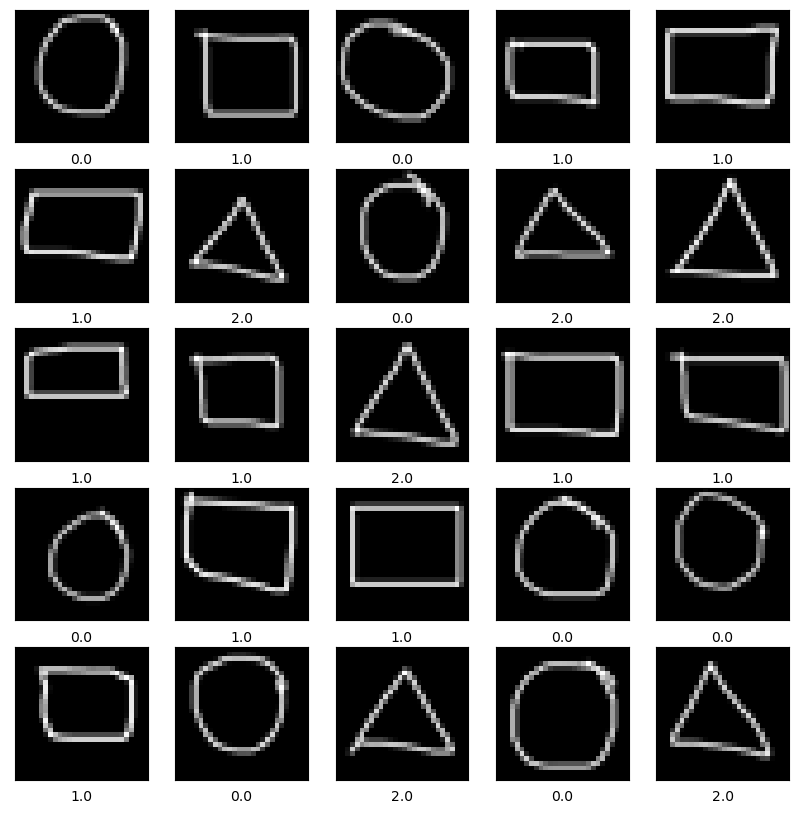

In [131]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_train[i],axis=2), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [132]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(3, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy', 'accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 64)        9280      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 3, 3, 64)       

In [133]:
def create_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(32, (3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [149]:
base_model = create_model()
base_model.fit(x_train, 
               y_train, 
               epochs= 120, 
               validation_data = (x_test, y_test)
            )


Epoch 1/120
2/2 [==============================] - 1s 413ms/step - loss: 1.0948 - accuracy: 0.3750 - val_loss: 1.1428 - val_accuracy: 0.1667
Epoch 2/120
2/2 [==============================] - 0s 31ms/step - loss: 1.0854 - accuracy: 0.3958 - val_loss: 1.1565 - val_accuracy: 0.1667
Epoch 3/120
2/2 [==============================] - 0s 33ms/step - loss: 1.0806 - accuracy: 0.3958 - val_loss: 1.1562 - val_accuracy: 0.1667
Epoch 4/120
2/2 [==============================] - 0s 35ms/step - loss: 1.0694 - accuracy: 0.3750 - val_loss: 1.1515 - val_accuracy: 0.1667
Epoch 5/120
2/2 [==============================] - 0s 35ms/step - loss: 1.0645 - accuracy: 0.3750 - val_loss: 1.1470 - val_accuracy: 0.1667
Epoch 6/120
2/2 [==============================] - 0s 34ms/step - loss: 1.0532 - accuracy: 0.3750 - val_loss: 1.1246 - val_accuracy: 0.1667
Epoch 7/120
2/2 [==============================] - 0s 34ms/step - loss: 1.0374 - accuracy: 0.4167 - val_loss: 1.1038 - val_accuracy: 0.4167
Epoch 8/120
2/2 [==

In [150]:
score = base_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))
print('Test loss: {:0.2f}%'.format(score[0] * 100))

Test accuracy: 100.00%
Test loss: 0.14%


1/1 [==============================] - 0s 61ms/step
['circle', 'rectangle', 'triangle']


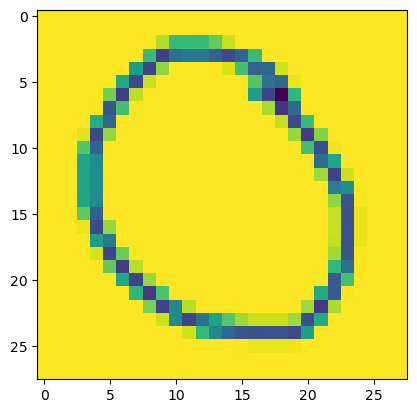

In [151]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = base_model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [ ]:
model_save_name = 'shape_detet.h5'
path = F"./models/{model_save_name}"

model.save(path)